In [139]:
import pandas as pd
import spacy
import textacy
import os
import logging
HOME = os.getcwd()
df = pd.read_csv(os.path.join(HOME, 'ethics_statement_frontiers_1000_spacy.csv'), usecols = ['parsed'])
#preproc = textacy.preprocessing.make_pipeline(textacy.preprocessing.normalize.unicode,textacy.preprocessing.normalize.quotation_marks,textacy.preprocessing.normalize.whitespace)
#preproc_records = ((preproc(text), meta) for text, meta in records)
parsed_paragraphs= df.parsed.to_list()

#Removing empty cells in the csv
new_parsed_paragraphs = []
for parsed_paragraph in parsed_paragraphs:
    if type(parsed_paragraph) == str :
        new_parsed_paragraphs.append(parsed_paragraph)
        

    
sentences_list = []

from nltk.tokenize import sent_tokenize
for paragraph in new_parsed_paragraphs:
    sentences_list.extend(sent_tokenize(paragraph))

for sentence in sentences_list:
    #sentence.encode().decode("utf-8")
    from unicodedata import normalize
    normalize('NFKD', sentence)
sentences_list

['The animal study was reviewed and approved by Ethics Committee of Endocrinology and Metabolism Research Institute of Tehran University of Medical Sciences (Code: EC-00214).',
 'The studies involving human participants were reviewed and approved by the University of Ceara Hospital Research Ethics Board (Protocol no.',
 '1886743).',
 'The patients/participants provided their written informed consent to participate in this study.',
 'We used an established protocol for cell isolation.',
 'When informed and written consent was given extracted third molars were used to prepare fibroblasts from the dental pulp.',
 'The protocol was approved by the Ethics committee of the Medical University of Vienna (631/2007).',
 'The studies involving human participants were reviewed and approved by the Finnish National Supervisory Authority for Welfare (Dnro V/74832/2017, V/3235/2019) and Health and the ethics committees of Helsinki University Central Hospital (382/13/03/01/2014, HUS/114/2018) and Turku

In [140]:
corpus = textacy.Corpus("en_core_web_sm", data=sentences_list)

print(corpus)

Corpus(918 docs, 19047 tokens)


Corpus(536 docs, 15631 tokens)


In [ ]:
import pandas as pd
import spacy
import textacy
import os
import logging
HOME = os.getcwd()
df = pd.read_csv(os.path.join(HOME, 'ethics_statement_frontiers_100.csv'), usecols = ['parsed'])
#print(df)
parsed_ethics_statement = df.parsed.to_list()
df_intro = pd.read_csv(os.path.join(HOME,'ethics_statement_Hindawi_50_20210708.csv'), usecols = ['parsed'])
#print(df)
parsed_intro = df_intro.parsed.to_list()
combined_parsed = parsed_ethics_statement + parsed_intro
for parsed_paragraph in combined_parsed:
    parsed_paragraph.encode().decode("utf-8")
corpus = textacy.Corpus("en_core_web_sm", data=combined_parsed)
print(corpus)

In [141]:
import textacy.extract
list(textacy.extract.entities(corpus[0]))

[Ethics Committee of Endocrinology,
 Metabolism Research Institute,
 Tehran University of Medical Sciences (Code]

In [142]:
from functools import partial
terms = list(textacy.extract.terms(
     corpus[0],
     ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ", 'VERB'}),ents=partial(textacy.extract.entities, include_types={"ORG", "GPE"}),dedupe=False),)
terms


[animal study,
 Ethics Committee of Endocrinology,
 Metabolism Research Institute,
 Tehran University of Medical Sciences (Code]

In [143]:
list(textacy.extract.terms_to_strings(terms, by="lemma"))


['animal study',
 'Ethics Committee of Endocrinology',
 'Metabolism Research Institute',
 'Tehran University of Medical Sciences ( code']

In [151]:
docs_terms = (
     textacy.extract.terms(
         doc,
         ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ", "VERB"}),
         ents=partial(textacy.extract.entities, include_types={"PERSON"}))
     for doc in corpus)
tokenized_docs = (
     textacy.extract.terms_to_strings(doc_terms, by="lemma")
     for doc_terms in docs_terms)

In [152]:
import textacy.representations
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs, tf_type="linear", idf_type="smooth")
doc_term_matrix

<918x360 sparse matrix of type '<class 'numpy.float64'>'
	with 2372 stored elements in Compressed Sparse Row format>

In [153]:
import textacy.tm
model = textacy.tm.TopicModel("nmf", n_topics=3)
model.fit(doc_term_matrix)

c:\users\shweata\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [154]:
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

(918, 3)

In [155]:
doc_topic_matrix

array([[0.        , 0.        , 0.28444348],
       [0.43182672, 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.03153595, 0.00642111, 0.07980505],
       [0.        , 0.39978048, 0.        ]])

In [156]:
id_to_term = {id_: term for term, id_ in vocab.items()}
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=8):
     print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: study involve   involve human   human participant   ethic committee   ethical committee   review board   local ethical   approval number
topic 1: write informed   informed consent   participant provide   legal guardian   national legislation   institutional requirement   identifiable image   datum include
topic 2: animal study   ethic committee   approval number   animal experimentation   animal experiment   ethical review   registration number   Sun Yat - Sen University


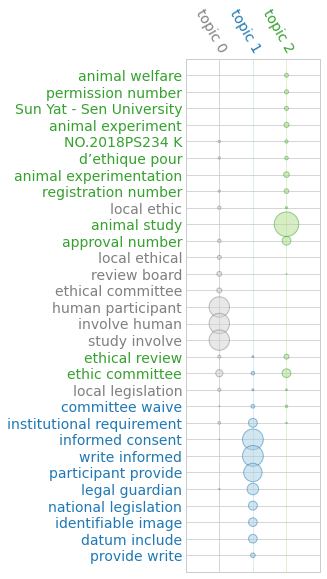

In [157]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[1,2,3,4,5,6])